# 01. Data Collection

This notebook collects electricity consumption data from the EIA API and other sources.

# 🔥 PHASE 0: Setup

In [12]:
# Import libraries
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import requests
from datetime import datetime, timedelta
import os
from dotenv import load_dotenv

# Add src to path
project_root = Path().parent.parent
sys.path.append(str(project_root / 'src'))

# Load environment variables (with error handling)
try:
    load_dotenv()
    print("✅ Environment variables loaded from .env file")
except Exception as e:
    print(f"⚠️  Could not load .env file: {e}")
    print("   Using default/fallback values")

# Set API key (if required)
EIA_API_KEY = os.getenv('EIA_API_KEY', 'wKelWGXySTQuKMv19FNYMhHH72y59QR3fhmb76mV')

# Define base URL
BASE_URL = "https://api.eia.gov/v2"

# Verify setup
print("✅ Setup complete!")
print(f"   📦 Pandas: {pd.__version__}")
print(f"   📦 NumPy: {np.__version__}")
print(f"   📦 Requests: {requests.__version__}")
print(f"   🔑 API Key: {EIA_API_KEY[:10]}...")
print(f"   🌐 Base URL: {BASE_URL}")

✅ Environment variables loaded from .env file
✅ Setup complete!
   📦 Pandas: 2.3.3
   📦 NumPy: 1.26.4
   📦 Requests: 2.32.5
   🔑 API Key: wKelWGXyST...
   🌐 Base URL: https://api.eia.gov/v2


# 🔥 PHASE 1: Data Ingestion Pipeline

## Step 1: Define Data Fetching Functions

In [2]:
def fetch_data(offset=0, length=5000):
    """
    Fetch retail sales data from EIA API
    
    Args:
        offset: Starting record number (for pagination)
        length: Number of records to fetch (max 5000 per request)
    
    Returns:
        Tuple of (DataFrame, total_count, has_more)
    """
    url = "https://api.eia.gov/v2/electricity/retail-sales/data/?frequency=monthly&data[0]=customers&data[1]=price&data[2]=revenue&data[3]=sales&sort[0][column]=period&sort[0][direction]=desc&offset={}&length={}"
    
    # Add API key to URL
    url_with_key = url.format(offset, length) + f"&api_key={EIA_API_KEY}"
    
    response = requests.get(url_with_key)
    response.raise_for_status()  # Raise an error for bad status codes
    
    json_response = response.json()
    data = json_response['response']['data']
    total_count = json_response['response'].get('total', len(data))
    
    # Convert total_count to int if it's a string
    try:
        total_count = int(total_count) if total_count is not None else len(data)
    except (ValueError, TypeError):
        total_count = len(data)
    
    df = pd.DataFrame(data)
    
    # Determine if there's more data to fetch
    # More data exists if we got a full batch AND haven't reached the total count
    has_more = len(data) == length and (offset + length) < total_count
    
    return df, total_count, has_more

In [3]:
def fetch_all_data():
    """
    Fetch all retail sales data from EIA API (handles pagination)
    
    Returns:
        DataFrame with all electricity retail sales data
    """
    print("🔄 Fetching data from EIA API...")
    all_dataframes = []
    offset = 0
    length = 5000
    total_count = None
    batch_num = 1
    
    while True:
        print(f"   Fetching batch {batch_num} (offset: {offset})...", end=" ")
        df_batch, total_count, has_more = fetch_data(offset=offset, length=length)
        all_dataframes.append(df_batch)
        print(f"✅ Got {len(df_batch)} records")
        
        if not has_more:
            break
        
        offset += length
        batch_num += 1
    
    # Combine all batches
    df_all = pd.concat(all_dataframes, ignore_index=True)
    print(f"\n✅ Total records fetched: {len(df_all):,}")
    print(f"   Expected total: {total_count:,}")
    
    return df_all

## Step 2: Fetch ALL Data

This will fetch all available data from the EIA API. It may take a few minutes depending on data size.

In [4]:
# Fetch ALL data (handles pagination automatically)
try:
    df_raw = fetch_all_data()
    print(f"\n✅ Data loaded successfully! Shape: {df_raw.shape}")
except Exception as e:
    print(f"❌ Error fetching data: {e}")
    print("   Please check your API key and internet connection, then re-run this cell.")
    raise

🔄 Fetching data from EIA API...
   Fetching batch 1 (offset: 0)... ✅ Got 5000 records
   Fetching batch 2 (offset: 5000)... ✅ Got 5000 records
   Fetching batch 3 (offset: 10000)... ✅ Got 5000 records
   Fetching batch 4 (offset: 15000)... ✅ Got 5000 records
   Fetching batch 5 (offset: 20000)... ✅ Got 5000 records
   Fetching batch 6 (offset: 25000)... ✅ Got 5000 records
   Fetching batch 7 (offset: 30000)... ✅ Got 5000 records
   Fetching batch 8 (offset: 35000)... ✅ Got 5000 records
   Fetching batch 9 (offset: 40000)... ✅ Got 5000 records
   Fetching batch 10 (offset: 45000)... ✅ Got 5000 records
   Fetching batch 11 (offset: 50000)... ✅ Got 5000 records
   Fetching batch 12 (offset: 55000)... ✅ Got 5000 records
   Fetching batch 13 (offset: 60000)... ✅ Got 5000 records
   Fetching batch 14 (offset: 65000)... ✅ Got 5000 records
   Fetching batch 15 (offset: 70000)... ✅ Got 5000 records
   Fetching batch 16 (offset: 75000)... ✅ Got 5000 records
   Fetching batch 17 (offset: 80000)..

# 🔥 PHASE 2: Data Exploration

## Step 3: Initial Data Exploration

Let's explore the raw data to understand its structure and identify preprocessing needs.

**Note:** Make sure the data fetching cell completed successfully before running the exploration cells below.

In [5]:
# Check if df_raw exists, if not try to load from saved file
try:
    # Try to access df_raw
    _ = df_raw.shape
    print("✅ Using df_raw from memory")
except (NameError, AttributeError):
    print("⚠️  df_raw not found. Attempting to load from saved file...")
    
    # Try to find the most recent raw data file
    data_raw_dir = project_root / 'data' / 'raw'
    if data_raw_dir.exists():
        csv_files = list(data_raw_dir.glob('eia_retail_sales_raw_*.csv'))
        if csv_files:
            # Get the most recent file
            latest_file = max(csv_files, key=lambda p: p.stat().st_mtime)
            print(f"📂 Loading from: {latest_file.name}")
            df_raw = pd.read_csv(latest_file)
            print(f"✅ Loaded {len(df_raw):,} records from saved file")
        else:
            print("❌ No saved data files found.")
            print("   Please run the data fetching cell above first.")
            raise NameError("df_raw is not defined. Please fetch data first.")
    else:
        print("❌ Data directory not found.")
        print("   Please run the data fetching cell above first.")
        raise NameError("df_raw is not defined. Please fetch data first.")

# Basic data overview
print("=" * 60)
print("📊 RAW DATA OVERVIEW")
print("=" * 60)
print(f"\n📏 Shape: {df_raw.shape[0]:,} rows × {df_raw.shape[1]} columns")
print(f"\n📅 Date Range:")
print(f"   First period: {df_raw['period'].min()}")
print(f"   Last period: {df_raw['period'].max()}")

print(f"\n🏛️  States: {df_raw['stateid'].nunique()} unique states")
print(f"   {sorted(df_raw['stateid'].unique())}")

print(f"\n🏭 Sectors: {df_raw['sectorid'].nunique()} unique sectors")
print(f"   {sorted(df_raw['sectorid'].unique())}")

print("\n" + "=" * 60)
print("📋 COLUMN INFORMATION")
print("=" * 60)
print(df_raw.info())

✅ Using df_raw from memory
📊 RAW DATA OVERVIEW

📏 Shape: 110,112 rows × 13 columns

📅 Date Range:
   First period: 2001-01
   Last period: 2025-08

🏛️  States: 62 unique states
   ['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'ENC', 'ESC', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MAT', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'MTN', 'NC', 'ND', 'NE', 'NEW', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PACC', 'PACN', 'RI', 'SAT', 'SC', 'SD', 'TN', 'TX', 'US', 'UT', 'VA', 'VT', 'WA', 'WI', 'WNC', 'WSC', 'WV', 'WY']

🏭 Sectors: 6 unique sectors
   ['ALL', 'COM', 'IND', 'OTH', 'RES', 'TRA']

📋 COLUMN INFORMATION
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110112 entries, 0 to 110111
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   period            110112 non-null  object
 1   stateid           110112 non-null  object
 2   stateDescription  110112 non-null 

In [6]:
# Display first few rows
print("=" * 60)
print("👀 FIRST 10 ROWS")
print("=" * 60)
print(df_raw.head(10))

👀 FIRST 10 ROWS
    period stateid stateDescription sectorid      sectorName customers  price  \
0  2025-08      AK           Alaska      ALL     all sectors    362846  24.02   
1  2025-08      AK           Alaska      COM      commercial     58428  23.01   
2  2025-08      AK           Alaska      IND      industrial      1244  21.26   
3  2025-08      AK           Alaska      OTH           other      None   None   
4  2025-08      AK           Alaska      RES     residential    303174  27.71   
5  2025-08      AK           Alaska      TRA  transportation         0      0   
6  2025-08      AL          Alabama      ALL     all sectors   2843428  12.79   
7  2025-08      AL          Alabama      COM      commercial    395483   14.4   
8  2025-08      AL          Alabama      IND      industrial      7261   7.72   
9  2025-08      AL          Alabama      OTH           other      None   None   

      revenue       sales      customers-units              price-units  \
0   113.03779   4

In [7]:
# Check for missing values
print("=" * 60)
print("🔍 MISSING VALUES ANALYSIS")
print("=" * 60)
missing = df_raw.isnull().sum()
missing_pct = (missing / len(df_raw)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Missing Percentage': missing_pct
})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)
print(missing_df)

if len(missing_df) == 0:
    print("\n✅ No missing values found!")
else:
    print(f"\n⚠️  {len(missing_df)} columns have missing values")

🔍 MISSING VALUES ANALYSIS
           Missing Count  Missing Percentage
customers          44392           40.315315
price              18352           16.666667
revenue            18352           16.666667
sales              18352           16.666667

⚠️  4 columns have missing values


In [8]:
# Check data types and sample values
print("=" * 60)
print("🔢 DATA TYPES & SAMPLE VALUES")
print("=" * 60)
for col in df_raw.columns:
    print(f"\n📌 {col}:")
    print(f"   Type: {df_raw[col].dtype}")
    print(f"   Unique values: {df_raw[col].nunique()}")
    if df_raw[col].dtype == 'object':
        sample_values = df_raw[col].dropna().unique()[:5]
        print(f"   Sample values: {list(sample_values)}")
    else:
        print(f"   Min: {df_raw[col].min()}, Max: {df_raw[col].max()}")

🔢 DATA TYPES & SAMPLE VALUES

📌 period:
   Type: object
   Unique values: 296
   Sample values: ['2025-08', '2025-07', '2025-06', '2025-05', '2025-04']

📌 stateid:
   Type: object
   Unique values: 62
   Sample values: ['AK', 'AL', 'AR', 'AZ', 'CA']

📌 stateDescription:
   Type: object
   Unique values: 62
   Sample values: ['Alaska', 'Alabama', 'Arkansas', 'Arizona', 'California']

📌 sectorid:
   Type: object
   Unique values: 6
   Sample values: ['ALL', 'COM', 'IND', 'OTH', 'RES']

📌 sectorName:
   Type: object
   Unique values: 6
   Sample values: ['all sectors', 'commercial', 'industrial', 'other', 'residential']

📌 customers:
   Type: object
   Unique values: 49263
   Sample values: ['362846', '58428', '1244', '303174', '0']

📌 price:
   Type: object
   Unique values: 3100
   Sample values: ['24.02', '23.01', '21.26', '27.71', '0']

📌 revenue:
   Type: object
   Unique values: 84087
   Sample values: ['113.03779', '48.60317', '24.43631', '39.99831', '0']

📌 sales:
   Type: object


In [9]:
# Statistical summary for numeric columns
print("=" * 60)
print("📈 STATISTICAL SUMMARY")
print("=" * 60)

# Convert numeric columns (they might be stored as strings)
numeric_cols = ['customers', 'price', 'revenue', 'sales']
for col in numeric_cols:
    if col in df_raw.columns:
        # Convert to numeric, handling 'None' strings
        df_raw[col] = pd.to_numeric(df_raw[col], errors='coerce')

print(df_raw[numeric_cols].describe())

📈 STATISTICAL SUMMARY
          customers         price       revenue          sales
count  6.572000e+04  91760.000000  91760.000000   91760.000000
mean   2.939946e+06      9.518629    604.270447    6014.848993
std    1.210875e+07      5.231911   2238.732942   21442.701377
min    0.000000e+00      0.000000     -0.000010       0.000000
25%    4.938000e+03      6.730000     30.088248     288.586380
50%    3.027645e+05      8.980000    124.417840    1451.580415
75%    2.045894e+06     11.650000    432.670640    4360.588210
max    1.652490e+08    116.670000  58596.122470  407230.479880


# 🔥 PHASE 3: Save Raw Data

## Step 4: Save Raw Data

Save the raw data to `data/raw/` for later preprocessing.

In [10]:
# Create data directories if they don't exist
data_raw_dir = project_root / 'data' / 'raw'
data_raw_dir.mkdir(parents=True, exist_ok=True)

# Generate filename with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"eia_retail_sales_raw_{timestamp}.csv"
filepath = data_raw_dir / filename

# Save raw data as CSV
print(f"💾 Saving raw data to: {filepath}")
df_raw.to_csv(filepath, index=False)
print(f"✅ Raw data saved successfully!")
print(f"   File size: {filepath.stat().st_size / (1024*1024):.2f} MB")
print(f"   Records: {len(df_raw):,}")

# Also save as parquet for better performance (optional)
try:
    parquet_filename = f"eia_retail_sales_raw_{timestamp}.parquet"
    parquet_filepath = data_raw_dir / parquet_filename
    df_raw.to_parquet(parquet_filepath, index=False)
    print(f"\n💾 Also saved as Parquet: {parquet_filepath}")
    print(f"   File size: {parquet_filepath.stat().st_size / (1024*1024):.2f} MB")
except Exception as e:
    print(f"\n⚠️  Could not save as Parquet: {e}")
    print("   CSV file saved successfully - Parquet is optional")

# Store the filepath for reference
print(f"\n📁 Raw data file: {filepath.name}")

💾 Saving raw data to: data/raw/eia_retail_sales_raw_20251120_012123.csv
✅ Raw data saved successfully!
   File size: 15.35 MB
   Records: 110,112

⚠️  Could not save as Parquet: Unable to find a usable engine; tried using: 'pyarrow', 'fastparquet'.
A suitable version of pyarrow or fastparquet is required for parquet support.
Trying to import the above resulted in these errors:
 - Missing optional dependency 'pyarrow'. pyarrow is required for parquet support. Use pip or conda to install pyarrow.
 - Missing optional dependency 'fastparquet'. fastparquet is required for parquet support. Use pip or conda to install fastparquet.
   CSV file saved successfully - Parquet is optional

📁 Raw data file: eia_retail_sales_raw_20251120_012123.csv


# 🔥 PHASE 4: Identify Preprocessing Needs

## Step 5: Document Preprocessing Requirements

Based on the exploration above, document what preprocessing steps will be needed.

In [11]:
# Summary of preprocessing needs
print("=" * 60)
print("🔧 PREPROCESSING REQUIREMENTS IDENTIFIED")
print("=" * 60)

preprocessing_needs = []

# 1. Data type conversions
if df_raw['customers'].dtype == 'object' or df_raw['price'].dtype == 'object':
    preprocessing_needs.append("✅ Convert numeric columns (customers, price, revenue, sales) from string to numeric")
    preprocessing_needs.append("   - Handle 'None' strings as NaN")
    preprocessing_needs.append("   - Convert to float64 for calculations")

# 2. Date handling
if df_raw['period'].dtype == 'object':
    preprocessing_needs.append("✅ Convert 'period' column to datetime")
    preprocessing_needs.append("   - Format appears to be YYYY-MM")

# 3. Missing values
missing_cols = df_raw.isnull().sum()
if missing_cols.sum() > 0:
    preprocessing_needs.append(f"✅ Handle missing values in {len(missing_cols[missing_cols > 0])} columns")
    for col in missing_cols[missing_cols > 0].index:
        pct = (missing_cols[col] / len(df_raw)) * 100
        preprocessing_needs.append(f"   - {col}: {missing_cols[col]:,} ({pct:.1f}%)")

# 4. Categorical encoding
categorical_cols = ['stateid', 'stateDescription', 'sectorid', 'sectorName']
preprocessing_needs.append("✅ Ensure categorical columns are properly typed")
preprocessing_needs.append(f"   - Columns: {', '.join(categorical_cols)}")

# 5. Units standardization
if 'customers-units' in df_raw.columns:
    preprocessing_needs.append("✅ Standardize units (may need to extract to separate columns or document)")

# 6. Data validation
preprocessing_needs.append("✅ Add data validation checks")
preprocessing_needs.append("   - Check for negative values in numeric columns")
preprocessing_needs.append("   - Validate date ranges")
preprocessing_needs.append("   - Check for outliers")

# 7. Feature engineering opportunities
preprocessing_needs.append("✅ Potential feature engineering:")
preprocessing_needs.append("   - Extract year and month from period")
preprocessing_needs.append("   - Calculate derived metrics (e.g., revenue per customer)")
preprocessing_needs.append("   - Create time-based features for forecasting")

print("\n".join(preprocessing_needs))
print("\n" + "=" * 60)
print("📝 Next Steps:")
print("   1. Review the raw data structure above")
print("   2. Implement preprocessing pipeline based on identified needs")
print("   3. Save preprocessed data to data/processed/")
print("=" * 60)

🔧 PREPROCESSING REQUIREMENTS IDENTIFIED
✅ Convert 'period' column to datetime
   - Format appears to be YYYY-MM
✅ Handle missing values in 4 columns
   - customers: 44,392 (40.3%)
   - price: 18,352 (16.7%)
   - revenue: 18,352 (16.7%)
   - sales: 18,352 (16.7%)
✅ Ensure categorical columns are properly typed
   - Columns: stateid, stateDescription, sectorid, sectorName
✅ Standardize units (may need to extract to separate columns or document)
✅ Add data validation checks
   - Check for negative values in numeric columns
   - Validate date ranges
   - Check for outliers
✅ Potential feature engineering:
   - Extract year and month from period
   - Calculate derived metrics (e.g., revenue per customer)
   - Create time-based features for forecasting

📝 Next Steps:
   1. Review the raw data structure above
   2. Implement preprocessing pipeline based on identified needs
   3. Save preprocessed data to data/processed/


Preprocessing 

In [21]:
!pip install scikit-learn


  Using cached scikit_learn-1.7.2-cp314-cp314-macosx_12_0_arm64.whl.metadata (11 kB)
  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.7.2-cp314-cp314-macosx_12_0_arm64.whl (8.6 MB)
Using cached joblib-1.5.2-py3-none-any.whl (308 kB)
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [scikit-learn] [scikit-learn]


In [ ]:
# Convert 'period' column to datetime

df = pd.read_csv('data/raw/eia_retail_sales_raw_20251120_012123.csv')

df['period'] = pd.to_datetime(df['period'], format='%Y-%m')


#Handle missing values (since missing values are relevant to the data, we will fill them with 0)
df.fillna(0, inplace=True)
df.isnull().sum()


# Encoding categorical variables 

import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Label Encode short ID columns

label_cols = ['stateid', 'sectorid']
le = LabelEncoder()

for col in label_cols:
    df[col] = le.fit_transform(df[col])


# 3. One-Hot Encode descriptive columns

one_hot_cols = [
    'stateDescription',
    'sectorName',
    'customers-units',
    'price-units',
    'revenue-units',
    'sales-units'
]

df_encoded = pd.get_dummies(df, columns=one_hot_cols, drop_first=True)


df_encoded.head()




,period,stateid,sectorid,customers,price,revenue,sales,stateDescription_Alaska,stateDescription_Arizona,stateDescription_Arkansas,...,stateDescription_West North Central,stateDescription_West South Central,stateDescription_West Virginia,stateDescription_Wisconsin,stateDescription_Wyoming,sectorName_commercial,sectorName_industrial,sectorName_other,sectorName_residential,sectorName_transportation
0,2025-08-01,0,0,362846.0,24.02,113.03779,470.53238,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2025-08-01,0,1,58428.0,23.01,48.60317,211.21155,True,False,False,...,False,False,False,False,False,True,False,False,False,False
2,2025-08-01,0,2,1244.0,21.26,24.43631,114.95066,True,False,False,...,False,False,False,False,False,False,True,False,False,False
3,2025-08-01,0,3,0.0,0.00,0.00000,0.00000,True,False,False,...,False,False,False,False,False,False,False,True,False,False
4,2025-08-01,0,4,303174.0,27.71,39.99831,144.37018,True,False,False,...,False,False,False,False,False,False,False,False,True,False


FEATURE ENGINEERING

In [24]:
#  Standardize Unit Columns

# Ensure numeric columns are actually numeric
numeric_cols = ['customers', 'price', 'revenue', 'sales']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')


for col in numeric_cols:
    negatives = df[df[col] < 0]
    if not negatives.empty:
        print(f"Negative values found in {col}:")
        display(negatives)
    else:
        print(f"No negative values in {col}")



No negative values in customers
No negative values in price
Negative values found in revenue:


,period,stateid,stateDescription,sectorid,sectorName,customers,price,revenue,sales,customers-units,price-units,revenue-units,sales-units
15671,2022-02-01,7,District of Columbia,5,transportation,3.0,0.0,-0.00001,19.90724,number of customers,cents per kilowatt-hour,million dollars,million kilowatt hours
49151,2014-08-01,7,District of Columbia,5,transportation,1.0,0.0,-0.00001,29.18429,number of customers,cents per kilowatt-hour,million dollars,million kilowatt hours


No negative values in sales


In [25]:
# Validate date ranges


print("Min date:", df['period'].min())
print("Max date:", df['period'].max())


Min date: 2001-01-01 00:00:00
Max date: 2025-08-01 00:00:00


In [26]:
# Detect outliers using z-score 

from scipy.stats import zscore

df['sales_z'] = zscore(df['sales'])

outliers = df[df['sales_z'].abs() > 3]
outliers.head()


,period,stateid,stateDescription,sectorid,sectorName,customers,price,revenue,sales,customers-units,price-units,revenue-units,sales-units,sales_z
282,2025-08-01,47,South Atlantic,0,all sectors,35378144.0,12.81,10913.67255,85189.44175,number of customers,cents per kilowatt-hour,million dollars,million kilowatt hours,4.069438
312,2025-08-01,52,U.S. Total,0,all sectors,165243780.0,14.26,55923.22005,392289.78977,number of customers,cents per kilowatt-hour,million dollars,million kilowatt hours,19.656512
313,2025-08-01,52,U.S. Total,1,commercial,19658470.0,14.04,19798.96496,140989.79700,number of customers,cents per kilowatt-hour,million dollars,million kilowatt hours,6.901621
314,2025-08-01,52,U.S. Total,2,industrial,1151320.0,9.06,8609.87258,95055.09152,number of customers,cents per kilowatt-hour,million dollars,million kilowatt hours,4.570175
316,2025-08-01,52,U.S. Total,4,residential,144433909.0,17.62,27421.59154,155620.56200,number of customers,cents per kilowatt-hour,million dollars,million kilowatt hours,7.644214


In [30]:
# Extract year and month

df['year'] = df['period'].dt.year
df['month'] = df['period'].dt.month



In [32]:
# Revenue per customer

df['revenue_per_customer'] = df['revenue'] * 1e6 / df['customers']

# Sales per customer (kWh per customer)

df['sales_per_customer'] = df['sales'] * 1e6 / df['customers']

# Price difference from previous month

df['price_prev_month'] = df.groupby('stateid')['price'].shift(1)
df['price_change'] = df['price'] - df['price_prev_month']


# Month-over-month change in consumption

df['sales_prev'] = df.groupby('stateid')['sales'].shift(1)
df['sales_change_pct'] = (df['sales'] - df['sales_prev']) / df['sales_prev'] * 100

# Rolling averages for forecasting

# 3-month rolling average

df['sales_rolling_3'] = df.groupby('stateid')['sales'].rolling(3).mean().reset_index(0, drop=True)

df.head(5)


,period,stateid,stateDescription,sectorid,sectorName,customers,price,revenue,sales,customers-units,...,year,month,month_name,revenue_per_customer,sales_per_customer,price_prev_month,price_change,sales_prev,sales_change_pct,sales_rolling_3
0,2025-08-01,0,Alaska,0,all sectors,362846.0,24.02,113.03779,470.53238,number of customers,...,2025,8,August,311.531035,1296.782602,NaN,NaN,NaN,NaN,NaN
1,2025-08-01,0,Alaska,1,commercial,58428.0,23.01,48.60317,211.21155,number of customers,...,2025,8,August,831.847231,3614.902957,24.02,-1.01,470.53238,-55.112218,NaN
2,2025-08-01,0,Alaska,2,industrial,1244.0,21.26,24.43631,114.95066,number of customers,...,2025,8,August,19643.336013,92404.067524,23.01,-1.75,211.21155,-45.575581,265.564863
3,2025-08-01,0,Alaska,3,other,0.0,0.00,0.00000,0.00000,number of customers,...,2025,8,August,NaN,NaN,21.26,-21.26,114.95066,-100.000000,108.720737
4,2025-08-01,0,Alaska,4,residential,303174.0,27.71,39.99831,144.37018,number of customers,...,2025,8,August,131.931861,476.195782,0.00,27.71,0.00000,inf,86.440280


In [47]:
df =df.fillna(0)

In [48]:
df.head(5)

,period,stateid,stateDescription,sectorid,sectorName,customers,price,revenue,sales,customers-units,...,year,month,month_name,revenue_per_customer,sales_per_customer,price_prev_month,price_change,sales_prev,sales_change_pct,sales_rolling_3
0,2025-08-01,0,Alaska,0,all sectors,362846.0,24.02,113.03779,470.53238,number of customers,...,2025,8,August,311.531035,1296.782602,0.00,0.00,0.00000,0.000000,0.000000
1,2025-08-01,0,Alaska,1,commercial,58428.0,23.01,48.60317,211.21155,number of customers,...,2025,8,August,831.847231,3614.902957,24.02,-1.01,470.53238,-55.112218,0.000000
2,2025-08-01,0,Alaska,2,industrial,1244.0,21.26,24.43631,114.95066,number of customers,...,2025,8,August,19643.336013,92404.067524,23.01,-1.75,211.21155,-45.575581,265.564863
3,2025-08-01,0,Alaska,3,other,0.0,0.00,0.00000,0.00000,number of customers,...,2025,8,August,0.000000,0.000000,21.26,-21.26,114.95066,-100.000000,108.720737
4,2025-08-01,0,Alaska,4,residential,303174.0,27.71,39.99831,144.37018,number of customers,...,2025,8,August,131.931861,476.195782,0.00,27.71,0.00000,inf,86.440280


Numerical Distribution

In [49]:
!pip install matplotlib seaborn pandas numpy scipy scikit-learn


Commercial vs Sales 

110112 110112


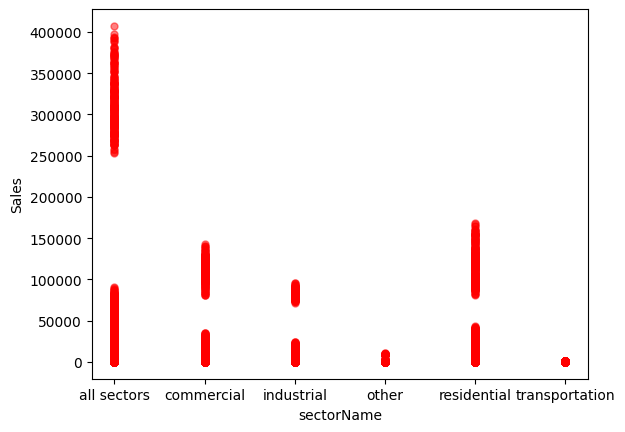

,period,stateid,stateDescription,sectorid,sectorName,customers,price,revenue,sales,customers-units,...,year,month,month_name,revenue_per_customer,sales_per_customer,price_prev_month,price_change,sales_prev,sales_change_pct,sales_rolling_3
0,2025-08-01,0,Alaska,0,all sectors,362846.0,24.02,113.03779,470.53238,number of customers,...,2025,8,August,311.531035,1296.782602,0.00,0.00,0.00000,0.000000,0.0
1,2025-08-01,0,Alaska,1,commercial,58428.0,23.01,48.60317,211.21155,number of customers,...,2025,8,August,831.847231,3614.902957,24.02,-1.01,470.53238,-55.112218,0.0


In [ ]:
import matplotlib.pyplot as plt

plt.plot(df['sectorName'], df['sales'], 'ro', markersize=5, alpha=0.5)
plt.xlabel('sectorName')
plt.ylabel('Sales')
plt.show()



PRICE VS REVENUE 

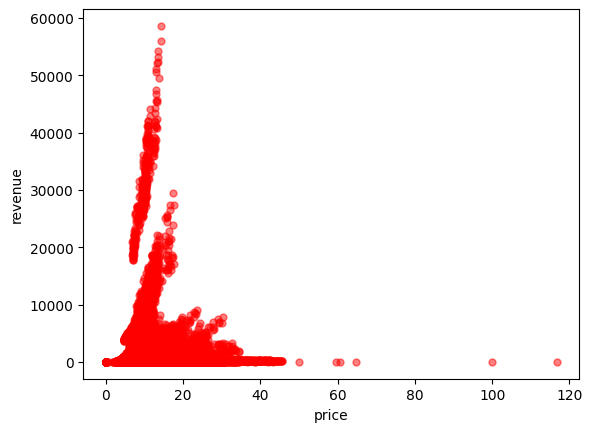

In [ ]:
import matplotlib.pyplot as plt

plt.plot(df['price'], df['revenue'], 'ro', markersize=5, alpha=0.5)
plt.xlabel('price')
plt.ylabel('revenue')
plt.show()





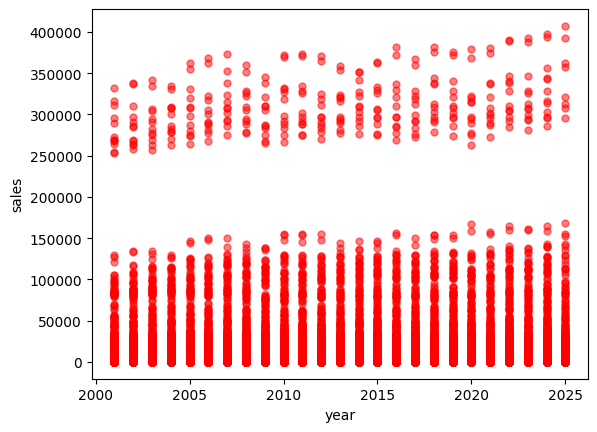

In [72]:
import matplotlib.pyplot as plt

plt.plot(df['year'], df['sales'], 'ro', markersize=5, alpha=0.5)
plt.xlabel('year')
plt.ylabel('sales')
plt.show()


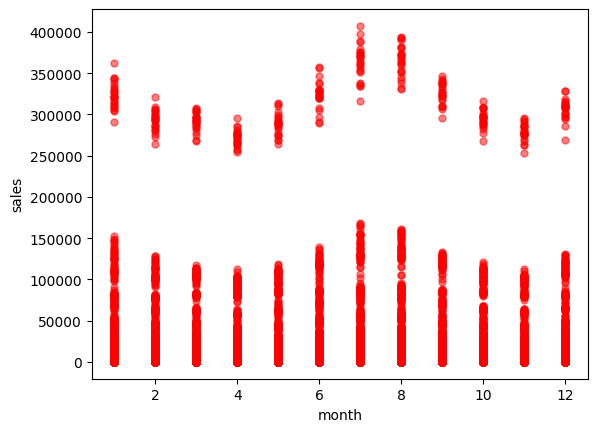

In [73]:
import matplotlib.pyplot as plt

plt.plot(df['month'], df['sales'], 'ro', markersize=5, alpha=0.5)
plt.xlabel('month')
plt.ylabel('sales')
plt.show()

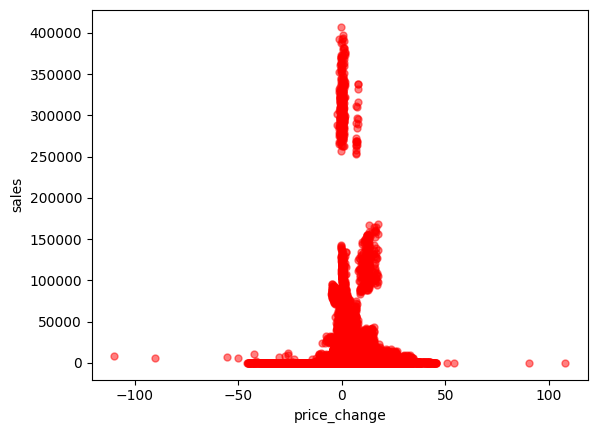

In [74]:
import matplotlib.pyplot as plt

plt.plot(df['price_change'], df['sales'], 'ro', markersize=5, alpha=0.5)
plt.xlabel('price_change')
plt.ylabel('sales')
plt.show()